<a href="https://colab.research.google.com/github/sahug/ds-nlp/blob/main/NLP%20-%20Session%2020%20-%20Bi%20Directional%20LSTM%20IMDB%20Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLP - Session 20 - Bi Directional LSTM IMDB Sentiment Analysis**

In [1]:
#Import Packages
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import nltk
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import callbacks, models, layers
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#Import Train Data
train = pd.read_csv("/content/labeledTrainData.tsv", sep="\t")
train.shape

(25000, 3)

In [3]:
#Import Test Data
test = pd.read_csv("/content/testData.tsv", sep="\t")
test.shape

(25000, 2)

In [4]:
#Remove Stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

def clean(review):
    clean_html = BeautifulSoup(review).get_text()
    clean_non_letters = re.sub("[^a-zA-Z]", " ", clean_html)
    cleaned_lowercase = clean_non_letters.lower()
    words = cleaned_lowercase.split()
    cleaned_words = [w for w in words if w not in stop_words]
    return " ".join(cleaned_words)

train["cleaned_review"] = train["review"].apply(clean)
train

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,sentiment,review,cleaned_review
0,5814_8,1,With all this stuff going down at the moment w...,stuff going moment mj started listening music ...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war worlds timothy hines entertaining ...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film starts manager nicholas bell giving welco...
3,3630_4,0,It must be assumed that those who praised this...,must assumed praised film greatest filmed oper...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious explo...
...,...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...,seems like consideration gone imdb reviews fil...
24996,5064_1,0,I don't believe they made this film. Completel...,believe made film completely unnecessary first...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil...",guy loser get girls needs build picked stronge...
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...,minute documentary bu uel made early one spain...


In [5]:
#Tokenization
MAX_WORDS = 25_000

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train.cleaned_review)
total_words = len(tokenizer.word_index) + 1
total_words

74066

In [6]:
sequences = tokenizer.texts_to_sequences(train.cleaned_review)
max_sequence_len = max([len(x) for x in sequences])
padded_sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding="pre"))
labels = np.array(train.sentiment)

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(20000, 1322) (20000,) (5000, 1322) (5000,)


In [7]:
def to_dataset(data, labels):
  dataset = tf.data.Dataset.from_tensor_slices((data, labels))
  dataset = dataset.cache().shuffle(X_train.shape[0] + 1).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

train_ds = to_dataset(X_train, y_train)
val_ds = to_dataset(X_val, y_val)

In [19]:
LSTM_SIZE = 8

def bi_lstm_model():
    model = models.Sequential()
    model.add(layers.Embedding(total_words, 16, input_length=max_sequence_len))
    model.add(layers.Bidirectional(layers.LSTM(LSTM_SIZE)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model, f'bidirectional_lstm_{LSTM_SIZE}'

def lstm_model():
    model = models.Sequential()
    model.add(layers.Embedding(total_words, 4, input_length=max_sequence_len))
    model.add(layers.LSTM(LSTM_SIZE))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model, f'lstm_{LSTM_SIZE}'

In [23]:
def tokenizer_train(model, name):
    reducer = callbacks.ReduceLROnPlateau(monior='val_loss', factor=0.5, patience=3, mode='min', cooldown=1)
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=6, mode='min', restore_best_weights=True)
    hist = model.fit(train_ds,
              epochs=10,
              verbose=1,
              callbacks=[stopper, reducer],
              validation_data=val_ds)
    results = model.evaluate(val_ds)
    model.save(f'/content/{name}')
    print(f"results: {results}, type: {type(results)}")
    return hist

In [24]:
model, name = lstm_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1322, 4)           296264    
                                                                 
 lstm_4 (LSTM)               (None, 8)                 416       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 296,689
Trainable params: 296,689
Non-trainable params: 0
_________________________________________________________________


In [25]:
hist = tokenizer_train(model, name)

Epoch 1/10
625/625 [==============================] - 338s 538ms/step - loss: 0.4783 - binary_accuracy: 0.7696 - val_loss: 0.3010 - val_binary_accuracy: 0.8872 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 334s 535ms/step - loss: 0.2233 - binary_accuracy: 0.9200 - val_loss: 0.2783 - val_binary_accuracy: 0.8910 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 333s 532ms/step - loss: 0.1296 - binary_accuracy: 0.9596 - val_loss: 0.3308 - val_binary_accuracy: 0.8864 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 333s 533ms/step - loss: 0.0808 - binary_accuracy: 0.9775 - val_loss: 0.3591 - val_binary_accuracy: 0.8840 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 328s 526ms/step - loss: 0.0574 - binary_accuracy: 0.9852 - val_loss: 0.3876 - val_binary_accuracy: 0.8754 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 332s 531ms/step - loss: 0.0331 - binary_accuracy: 0.9927 - val_loss: 0.4290 - val

INFO:tensorflow:Assets written to: /content/lstm_8/assets


INFO:tensorflow:Assets written to: /content/lstm_8/assets


results: [0.27834445238113403, 0.890999972820282], type: <class 'list'>


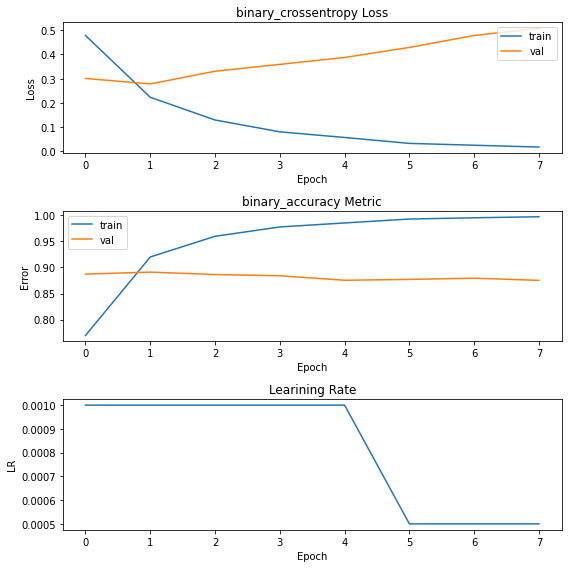

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(8,8), tight_layout=True)
    
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_title('binary_crossentropy Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='upper right')

axs[1].plot(hist.history['binary_accuracy'])
axs[1].plot(hist.history['val_binary_accuracy'])
axs[1].set_title('binary_accuracy Metric')
axs[1].set_ylabel('Error')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='upper left')

axs[2].plot(hist.history['lr'])
axs[2].set_title('Learining Rate')
axs[2].set_ylabel('LR')
axs[2].set_xlabel('Epoch')
plt.savefig(f'/content/{name}_graphs.png')
plt.show()

In [28]:
test["cleaned_review"] = test["review"].apply(clean)
test

,id,review,cleaned_review
0,12311_10,Naturally in a film who's main themes are of m...,naturally film main themes mortality nostalgia...
1,8348_2,This movie is a disaster within a disaster fil...,movie disaster within disaster film full great...
2,5828_4,"All in all, this is a movie for kids. We saw i...",movie kids saw tonight child loved one point k...
3,7186_2,Afraid of the Dark left me with the impression...,afraid dark left impression several different ...
4,12128_7,A very accurate depiction of small time mob li...,accurate depiction small time mob life filmed ...
...,...,...,...
24995,2155_10,"Sony Pictures Classics, I'm looking at you! So...",sony pictures classics looking sony got rights...
24996,59_10,I always felt that Ms. Merkerson had never got...,always felt ms merkerson never gotten role fit...
24997,2531_1,I was so disappointed in this movie. I am very...,disappointed movie familiar case read mark fuh...
24998,7772_8,"From the opening sequence, filled with black a...",opening sequence filled black white shots remi...


In [29]:
sequences = tokenizer.texts_to_sequences(test.cleaned_review)
test_sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))
print(test_sequences.shape)

(25000, 1322)


In [30]:
predictions = model.predict(test_sequences).flatten()

In [ ]:
predictions.shape

In [31]:
output = pd.DataFrame(data={"id":test.id, "sentiment":predictions})
output.to_csv("word_tokenization_model.csv", index=False, quoting=3)